In [192]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, ifft

import matplotlib.pyplot as plt

In [297]:
def LLG(t, m, Beff, gammaLL, alpha):
    return (
        -gammaLL
        * (np.cross(m, Beff) + alpha * np.cross(m, np.cross(m, Beff)))
        / (1 + alpha**2)
    )


def LLG_tdep(t, m, f_Beff, gammaLL, alpha):
    Beff = f_Beff(t)
    return (
        -gammaLL
        * (np.cross(m, Beff) + alpha * np.cross(m, np.cross(m, Beff)))
        / (1 + alpha**2)
    )


def f_Bext_factory(Bext, w_cutoff, h):
    def inner(t):
        return np.array([h * np.sinc(w_cutoff * t / np.pi), 0, Bext])

    return inner


def LLG_explicit_real(t, mxp, Bext, Brms, wc, kappa, N, gammaLL, alpha):
    m = mxp[:-2]
    xp = mxp[-2:]

    Beff = Bext + Brms * xp[0]
    dm = (
        -gammaLL
        * (np.cross(m, Beff) + alpha * np.cross(m, np.cross(m, Beff)))
        / (1 + alpha**2)
    )

    M = np.array([[-kappa, -wc], [wc, -kappa]])
    dxp = np.dot(M, xp)
    dxp[1] += -N * gammaLL * np.dot(Brms, m)

    return np.append(dm, dxp)


def LLG_explicit_real_tdep(t, mxp, f_Bext, Brms, wc, kappa, N, gammaLL, alpha):
    m = mxp[:-2]
    xp = mxp[-2:]
    Bext = f_Bext(t)

    Beff = Bext + Brms * xp[0]
    dm = (
        -gammaLL
        * (np.cross(m, Beff) + alpha * np.cross(m, np.cross(m, Beff)))
        / (1 + alpha**2)
    )

    M = np.array([[-kappa, -wc], [wc, -kappa]])
    dxp = np.dot(M, xp)
    dxp[1] += -N * gammaLL * np.dot(Brms, m)

    return np.append(dm, dxp)


def fft_wrapper(time, timeseries, slice_=None):
    if slice_:
        time = time[slice_]
        timeseries = timeseries[slice_]

    ws = fftfreq(len(time), time[1] - time[0])
    amps = fft(timeseries)

    return ws[: middle(ws)], amps[: middle(ws)]


def middle(seq):
    return len(seq) // 2


def free_photon_prop(w, wc):
    return 1 / (w - wc)


def matter_response(w, wc, wz, lam):
    num = 2 * wz * (wc**2 - w**2)
    den = (wc**2 - w**2) * (wz**2 - w**2) - 4 * lam**2 * wz * wc

    return num / den


def photon_prop_lenk(w, wc, chi, lam):
    D0 = free_photon_prop(w, wc)

    return D0 - D0**2 * lam**2 * chi


def f_alpha(mxs, ts, wc, lam, kappa, alpha0):
    dt = ts[1] - ts[0]
    I = 0
    alphas = np.empty([len(ts)], dtype=complex)
    alphas[0] = alpha0
    for i, t in enumerate(ts[1:], start=1):
        I += np.exp(kappa * t) * np.exp(1j * wc * t) * mxs[i] * dt
        alphas[i] = np.exp(-kappa * t) * (
            alpha0 * np.exp(-1j * wc * t) + 1j * lam * np.exp(-1j * wc * t) * I
        )
    return alphas


def f_alpha_general(ms, ts, Brms, wc, kappa, N, gammaLL, alpha0):
    dt = ts[1] - ts[0]
    I = 0
    alphas = np.empty([len(ts)], dtype=complex)
    alphas[0] = alpha0
    for i, t in enumerate(ts[1:], start=1):
        I += np.exp(kappa * t) * np.exp(1j * wc * t) * np.dot(Brms, ms[i]) * dt
        alphas[i] = np.exp(-kappa * t) * (
            alpha0 * np.exp(-1j * wc * t) + 1j * N * gammaLL * np.exp(-1j * wc * t) * I
        )
    return alphas


def polaritons(wz, wc, lam):
    def para(wz, wc, lam):
        innerroot = np.sqrt(wz**4 + wc**4 - 2 * wz**2 * wc**2 + 16 * lam**2 * wz * wc)
        return np.sqrt(0.5 * (wz**2 + wc**2 - innerroot)), np.sqrt(
            0.5 * (wz**2 + wc**2 + innerroot)
        )

    def ferro(wz, wc, lam):
        mu = wz * wc / (4 * lam**2)
        g = lam * mu * np.sqrt(2 / (1 + mu))
        wztilde = wz * (1 + mu) / (2 * mu)
        eps = wz * (1 - mu) * (3 + mu) / (8 * mu * (1 + mu))

        innerroot = np.sqrt(
            wztilde**4
            + wc**4
            - 2 * wztilde**2 * wc**2
            + 16 * g**2 * wztilde * wc
            + 4 * (eps**2 * wztilde**2 + eps * wztilde**3 - wc**2 * eps * wztilde)
        )
        return np.sqrt(
            0.5 * (wztilde**2 + wc**2 + 2 * eps * wztilde - innerroot)
        ), np.sqrt(0.5 * (wztilde**2 + wc**2 + 2 * eps * wztilde + innerroot))

    if 4 * lam**2 < wz * wc:
        # paramagnetic phase
        return para(wz, wc, lam)
    else:
        # ferromagnetic phase
        return ferro(wz, wc, lam)

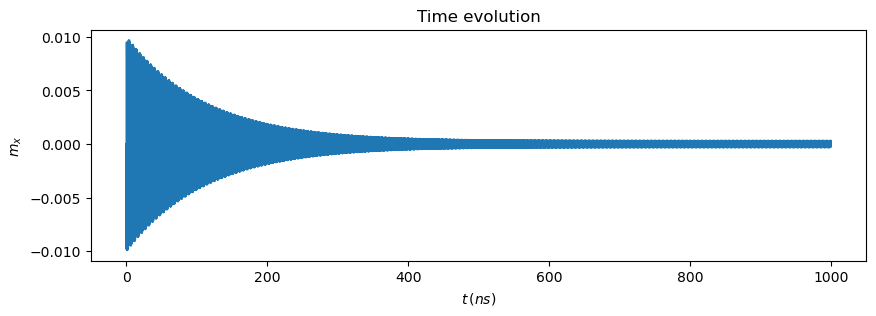

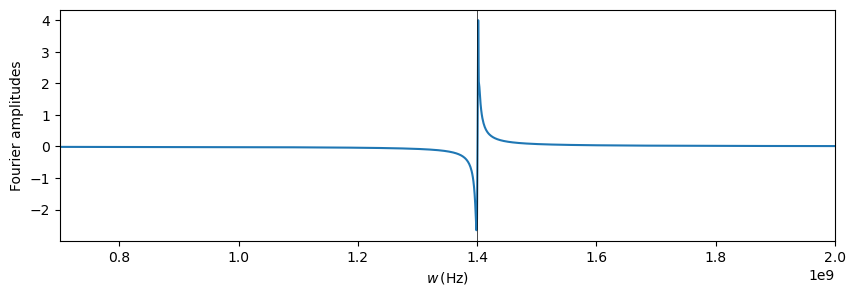

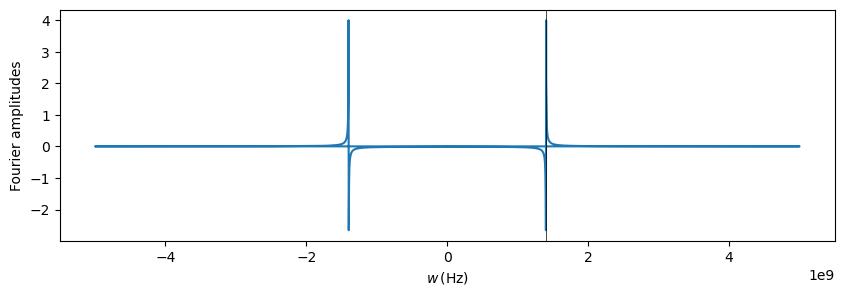

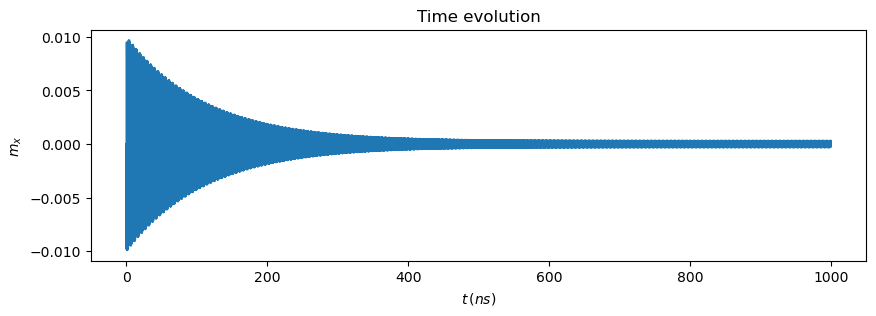

In [207]:
plt.rcParams["figure.figsize"] = (10, 3)

N = 100
tmax = 1000e-9
alpha = 1e-3
my0 = 0.01
m0 = np.array([0, my0, np.sqrt(1 - my0**2)])
gammaLL = 28e9 * 2 * np.pi
wz = 1.4e9
Beff = np.array([0, 0, 2 * np.pi * wz / gammaLL])
t_eval = np.linspace(0, tmax, 10000)
sol = solve_ivp(LLG, (0, tmax), m0, args=(Beff, gammaLL, alpha), t_eval=t_eval)
ws, amps = fft_wrapper(sol.t, sol.y[0])
alt_amps = fft(sol.y[0])
alt_ws = fftfreq(len(sol.t), sol.t[1] - sol.t[0])

plt.plot(sol.t * 1e9, sol.y[0])
plt.ylabel(r"$m_x$")
plt.xlabel(r"$t \, (ns)$")
plt.title("Time evolution")
plt.show()

plt.plot(ws[: len(ws) // 2], amps[: len(ws) // 2])
plt.xlim(0.7e9, 2e9)
plt.ylabel("Fourier amplitudes")
plt.xlabel(r"$w \, ({\rm Hz})$")
plt.axvline(1.4e9, c="k", lw=0.5)
plt.show()

plt.plot(alt_ws, alt_amps)
# plt.xlim(0.7e9, 2e9)
plt.ylabel("Fourier amplitudes")
plt.xlabel(r"$w \, ({\rm Hz})$")
plt.axvline(1.4e9, c="k", lw=0.5)
plt.show()

plt.plot(sol.t * 1e9, ry)
plt.ylabel(r"$m_x$")
plt.xlabel(r"$t \, (ns)$")
plt.title("Time evolution")
plt.show()

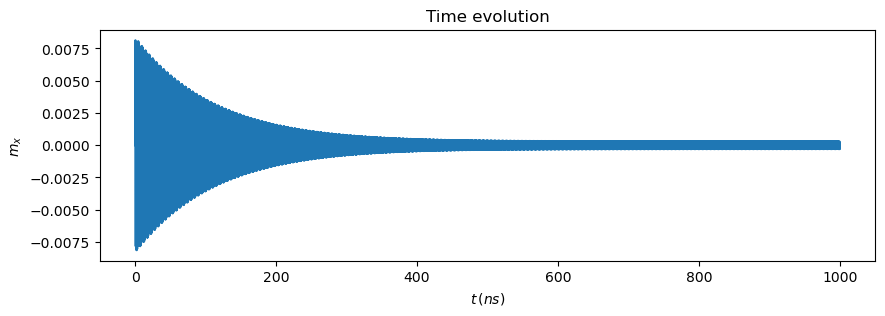

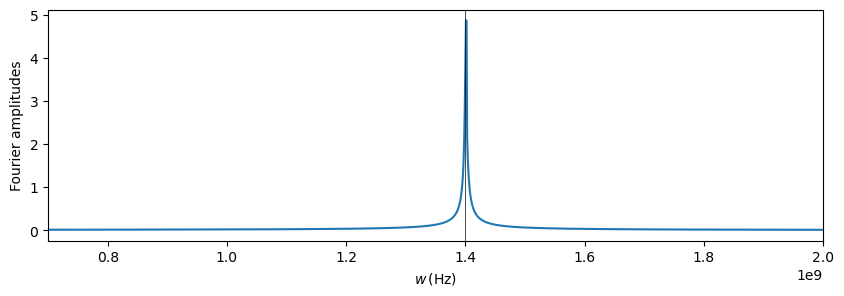

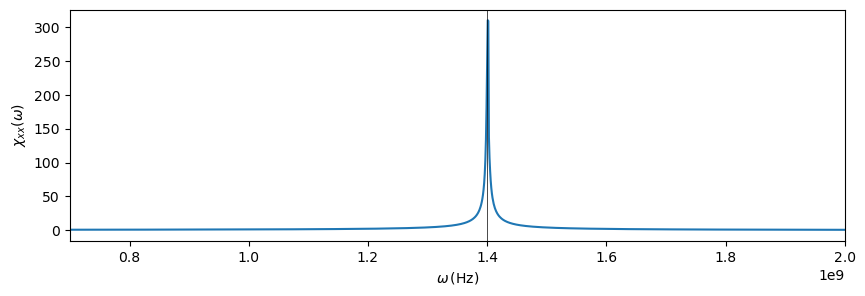

In [6]:
plt.rcParams["figure.figsize"] = (10, 3)

N = 10
tmax = 1000e-9
alpha = 1e-3
m0 = np.array([0, 0, 1])
gammaLL = 28e9 * 2 * np.pi
wz = 1.4e9
w_cutoff = 2 * 2 * np.pi * wz
Bext = 2 * np.pi * wz / gammaLL
h = 0.01 * Bext
f_Beff = f_Bext_factory(Bext, w_cutoff, h)
t_eval = np.linspace(0, tmax, 10000)
sol = solve_ivp(LLG_tdep, (0, tmax), m0, args=(f_Beff, gammaLL, alpha), t_eval=t_eval)
ws, amps = fft_wrapper(sol.t, sol.y[0])

plt.plot(sol.t * 1e9, sol.y[0])
plt.ylabel(r"$m_x$")
plt.xlabel(r"$t \, (ns)$")
plt.title("Time evolution")
plt.show()

plt.plot(ws, amps)
plt.xlim(0.7e9, 2e9)
plt.ylabel("Fourier amplitudes")
plt.xlabel(r"$w \, ({\rm Hz})$")
plt.axvline(1.4e9, c="k", lw=0.5)
plt.show()

chi = amps * w_cutoff / (gammaLL * h * np.pi)
plt.plot(ws, chi)
plt.xlim(0.7e9, 2e9)
plt.ylabel(r"$\chi_{xx}(\omega)$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.axvline(1.4e9, c="k", lw=0.5)
plt.show()

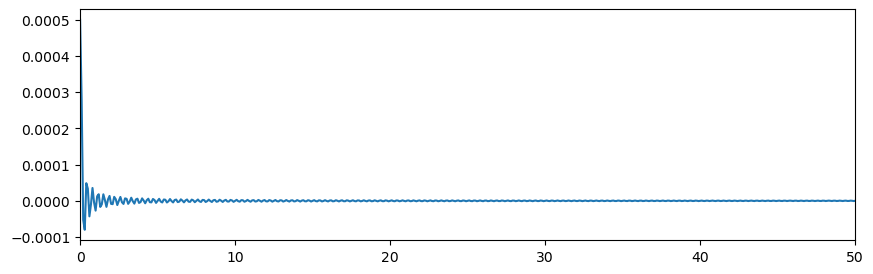

In [7]:
plt.plot(sol.t * 1e9, [f_Beff(t)[0] for t in sol.t])
plt.xlim(0, 50)
plt.show()

wzc/wc: 0.7466910823080258


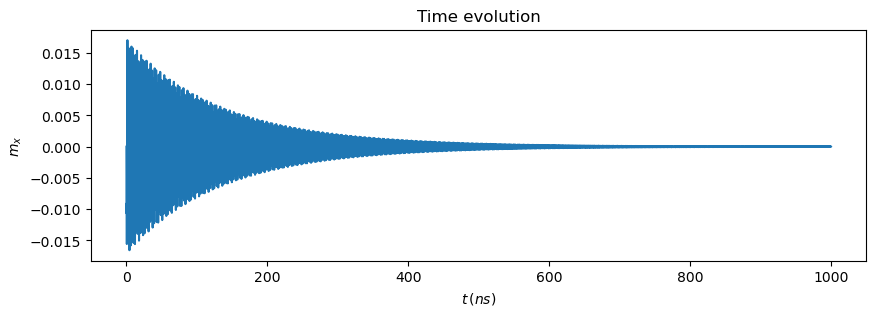

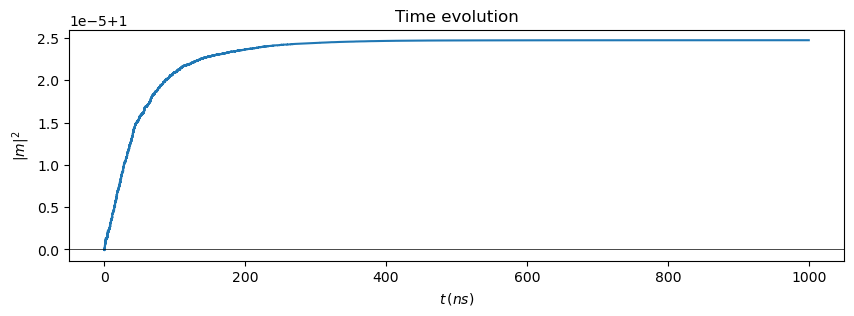

gap/lam: 1.153433211418139


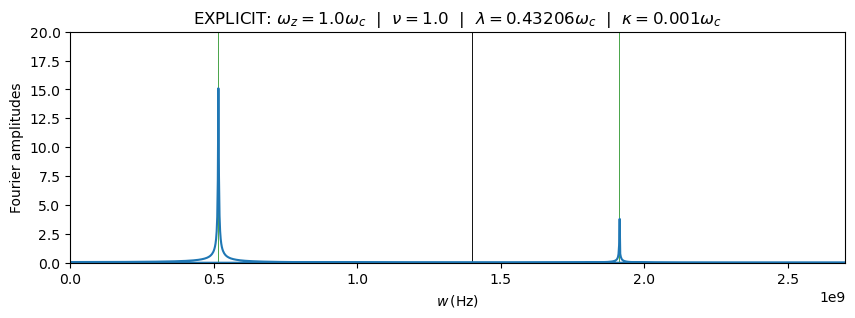

In [19]:
N = 1000
tmax = 1000e-9  # 1000
alpha = 1e-3
my0 = 0.01
m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
gammaLL = 28e9 * 2 * np.pi
wc = 1.4e9
wz = 1 * wc
kappa = 0.001 * wc
Bext = np.array([0, 0, 2 * np.pi * wz / gammaLL])
nu = 1.0
c = 5.124350564859e-19
rho = 5.1e26  # densidad espines FIJA
lam = np.sqrt(c * rho * nu * wc)
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])
wzc = 4 * lam**2 / wc  # freq espines critica, calculo indicativo
print("wzc/wc:", wzc / wc)

t_eval = np.linspace(0, tmax, 500000)  # 100000
# dt = 0.01e-9
sol = solve_ivp(
    LLG_explicit_real,
    (0, tmax),
    m0,
    method="RK45",
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha),
    t_eval=t_eval,
)  # , max_step=dt, atol = 1, rtol = 1
ws = fftfreq(
    len(sol.t) // 2, sol.t[1] - sol.t[0]
)  # discard first half of time evolution
amps = np.abs(fft(sol.y[0][len(sol.t) // 2 :]))  # discard first half of time evolution
plt.plot(sol.t * 1e9, sol.y[0])

# plt.xlim(0, 50)
plt.ylabel(r"$m_x$")
plt.xlabel(r"$t \, (ns)$")
plt.title("Time evolution")
plt.show()


plt.plot(
    sol.t * 1e9,
    [mx**2 + my**2 + mz**2 for mx, my, mz in zip(sol.y[0], sol.y[1], sol.y[2])],
)
plt.axhline(1.0, c="k", lw=0.5)
# plt.ylim(0, 1.1)
plt.ylabel(r"$|m|^2$")
plt.xlabel(r"$t \, (ns)$")
plt.title("Time evolution")
plt.show()

plt.axvline(wc, c="k", lw=0.5)
plt.axvline(wz, c="k", lw=0.5)

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c="g", lw=0.5)
# -----------------------------------------

print("gap/lam:", (pp - pm) / (2 * lam))

plt.plot(ws, amps)
# plt.xlim(0.1e9, 2e9)
plt.ylim(0, 20)
plt.xlim(0.0e9, 2.7e9)
plt.ylabel("Fourier amplitudes")
plt.xlabel(r"$w \, ({\rm Hz})$")
plt.title(
    "EXPLICIT: "
    + rf"$\omega_z = {wz / wc} \omega_c$"
    + "  |  "
    + rf"$\nu = {nu}$"
    + "  |  "
    + rf"$\lambda = {round(lam/wc, 5)} \omega_c$"
    + "  |  "
    + rf"$\kappa = {round(kappa/wc, 5)} \omega_c$"
)

plt.show()

wzc/wc: 0.7466910823080258
[ 3.52220968e+00-0.00000000e+00j  3.52225939e+00-8.02929992e-04j
  3.52230411e+00-1.63351641e-03j ... -1.59608226e-06+3.20915381e-09j
 -1.60146995e-06-7.22008558e-09j -1.61282678e-06-8.84498285e-09j]


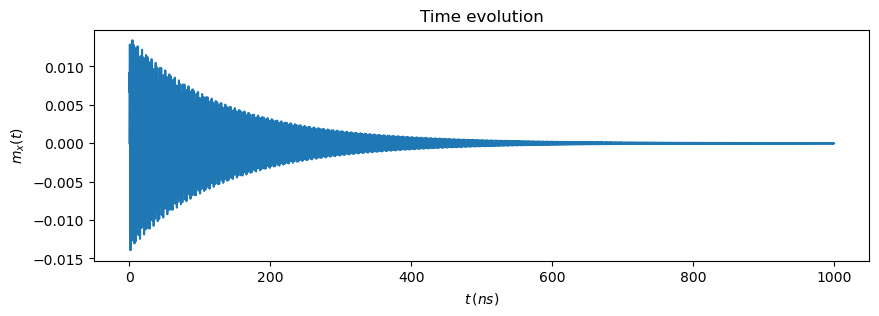

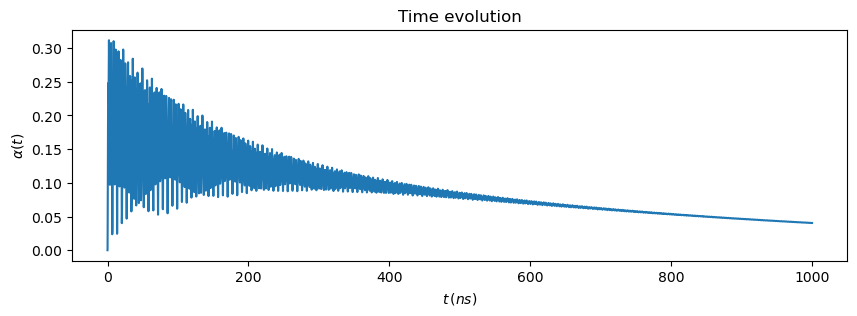

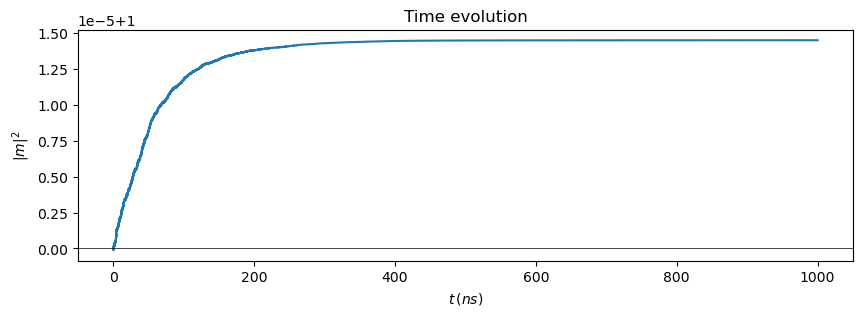

gap/lam: 1.153433211418139


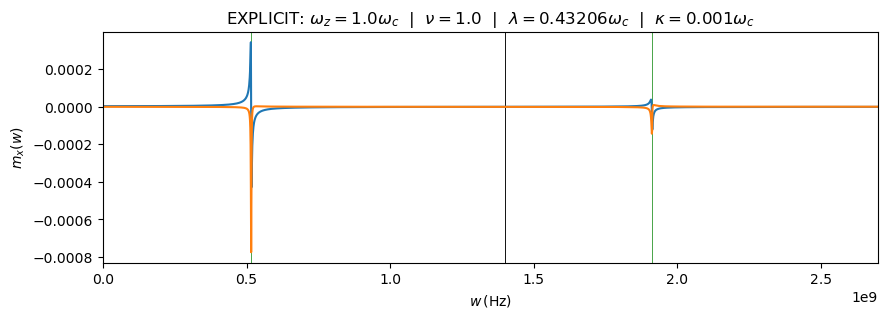

gap/lam: 1.153433211418139


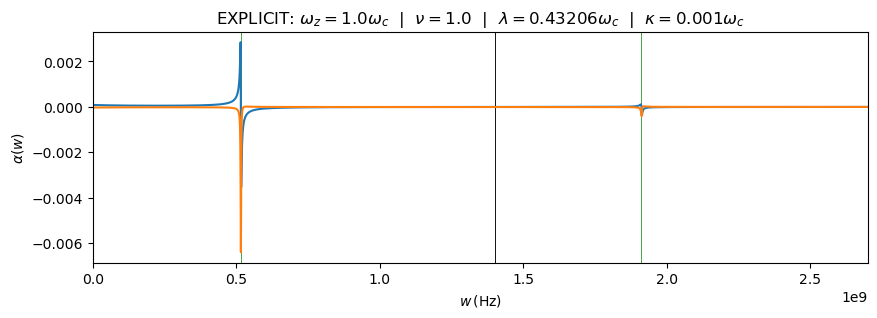

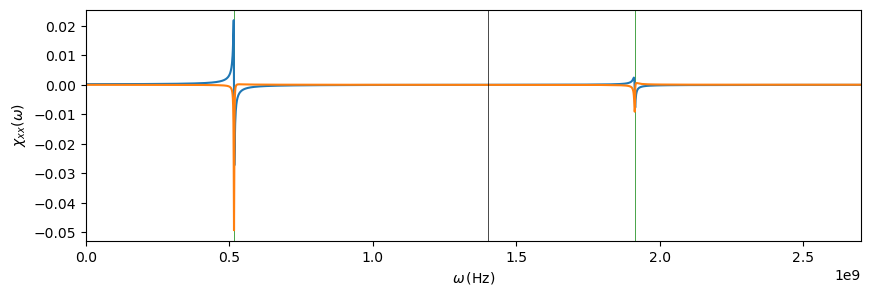

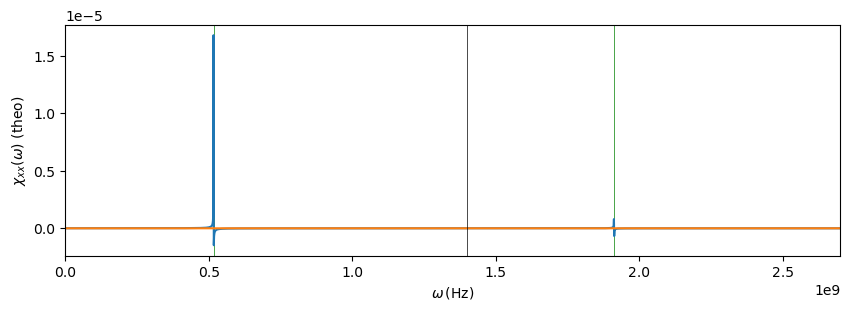

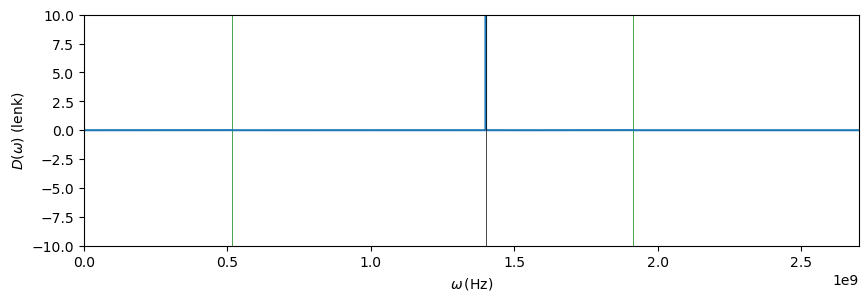

In [300]:
N = 1000
tmax = 1000e-9  # 1000
alpha = 1e-3
m0 = np.array([0, 0, 1, np.sqrt(N) * 0.0, 0])
alpha0 = 0.5 * (m0[3] - 1j * m0[4])  ##### AQUI
gammaLL = 28e9 * 2 * np.pi
wc = 1.4e9
wz = 1.0 * wc
w_cutoff = 2 * 2 * np.pi * wz
Bext = 2 * np.pi * wz / gammaLL
h = 0.01 * Bext
f_Bext = f_Bext_factory(Bext, w_cutoff, h)
kappa = 0.001 * wc
Bext = np.array([0, 0, 2 * np.pi * wz / gammaLL])
nu = 1.0
c = 5.124350564859e-19
rho = 5.1e26  # densidad espines FIJA
lam = np.sqrt(c * rho * nu * wc)
Brms = Brms_scalar = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])
wzc = 4 * lam**2 / wc  # freq espines critica, calculo indicativo
print("wzc/wc:", wzc / wc)

N_time = 1000000
t_eval = np.linspace(0, tmax, N_time)  # 100000
# dt = 0.01e-9
sol = solve_ivp(
    LLG_explicit_real_tdep,
    (0, tmax),
    m0,
    method="RK45",
    args=(f_Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha),
    t_eval=t_eval,
)  # , max_step=dt, atol = 1, rtol = 1
ws, amps = fft_wrapper(
    sol.t, sol.y[0]
)  # aquí ya no descarto el inicio de la evolución temporal
print(amps)
plt.plot(sol.t * 1e9, sol.y[0])
# plt.xlim(0, 50)
plt.ylabel(r"$m_x(t)$")
plt.xlabel(r"$t \, (ns)$")
plt.title("Time evolution")
plt.show()

# alphas = f_alpha(sol.y[0], sol.t, wc, lam, kappa, alpha0
ms = np.array([sol.y[:3, i] for i in range(len(sol.y[0]))])
alphas = f_alpha_general(ms, sol.t, Brms, wc, kappa, N, gammaLL, alpha0)  ##### AQUI
a_ws, a_amps = fft_wrapper(sol.t, alphas)
# plt.plot(sol.t * 1e9, alphas.real)
# plt.plot(sol.t * 1e9, alphas.imag)
plt.plot(sol.t * 1e9, np.abs(alphas))
# plt.axhline(np.amax(sol.y[0])*lam/wc)
# plt.xlim(0, 100)
plt.ylabel(r"$\alpha(t)$")
plt.xlabel(r"$t \, (ns)$")
plt.title("Time evolution")
plt.show()


plt.plot(
    sol.t * 1e9,
    [mx**2 + my**2 + mz**2 for mx, my, mz in zip(sol.y[0], sol.y[1], sol.y[2])],
)
plt.axhline(1.0, c="k", lw=0.5)
# plt.ylim(0, 1.1)
plt.ylabel(r"$|m|^2$")
plt.xlabel(r"$t \, (ns)$")
plt.title("Time evolution")
plt.show()

plt.axvline(wc, c="k", lw=0.5)
plt.axvline(wz, c="k", lw=0.5)

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c="g", lw=0.5)
# -----------------------------------------

print("gap/lam:", (pp - pm) / (2 * lam))
amps = amps / N_time
plt.plot(ws, amps.real)
plt.plot(ws, amps.imag)
# plt.xlim(0.1e9, 2e9)
# plt.ylim(0, 20)
plt.xlim(0.0e9, 2.7e9)
plt.ylabel("$m_x(w)$")
plt.xlabel(r"$w \, ({\rm Hz})$")
plt.title(
    "EXPLICIT: "
    + rf"$\omega_z = {wz / wc} \omega_c$"
    + "  |  "
    + rf"$\nu = {nu}$"
    + "  |  "
    + rf"$\lambda = {round(lam/wc, 5)} \omega_c$"
    + "  |  "
    + rf"$\kappa = {round(kappa/wc, 5)} \omega_c$"
)

plt.show()

plt.axvline(wc, c="k", lw=0.5)
plt.axvline(wz, c="k", lw=0.5)

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c="g", lw=0.5)
# -----------------------------------------

print("gap/lam:", (pp - pm) / (2 * lam))
a_amps = a_amps / N_time
plt.plot(a_ws, a_amps.real)
plt.plot(a_ws, a_amps.imag)
# plt.xlim(0.1e9, 2e9)
# plt.ylim(0, 20)
plt.xlim(0.0e9, 2.7e9)
plt.ylabel(r"$\alpha(w)$")
plt.xlabel(r"$w \, ({\rm Hz})$")
plt.title(
    "EXPLICIT: "
    + rf"$\omega_z = {wz / wc} \omega_c$"
    + "  |  "
    + rf"$\nu = {nu}$"
    + "  |  "
    + rf"$\lambda = {round(lam/wc, 5)} \omega_c$"
    + "  |  "
    + rf"$\kappa = {round(kappa/wc, 5)} \omega_c$"
)

plt.show()


# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c="g", lw=0.5)
# -----------------------------------------

chi = amps * w_cutoff / (gammaLL * h * np.pi)
plt.plot(ws, chi.real)
plt.plot(ws, chi.imag)
plt.xlim(0.0e9, 2.7e9)
plt.ylabel(r"$\chi_{xx}(\omega)$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.axvline(1.4e9, c="k", lw=0.5)
plt.show()

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c="g", lw=0.5)
# -----------------------------------------

eta = 0.001
plt.plot(ws, matter_response(ws + 1j * eta, wc, wz, lam).real)
plt.plot(ws, matter_response(ws + 1j * eta, wc, wz, lam).imag)
# plt.ylim(-1e4, 0)
plt.xlim(0.0e9, 2.7e9)
plt.ylabel(r"$\chi_{xx}(\omega)$ (theo)")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.axvline(1.4e9, c="k", lw=0.5)
plt.show()

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c="g", lw=0.5)
# -----------------------------------------

plt.plot(ws, photon_prop_lenk(ws, wc, chi.imag, lam))
plt.ylim(-1e1, 1e1)
plt.xlim(0.0e9, 2.7e9)
plt.ylabel(r"$D(\omega)$ (lenk)")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.axvline(1.4e9, c="k", lw=0.5)
plt.show()

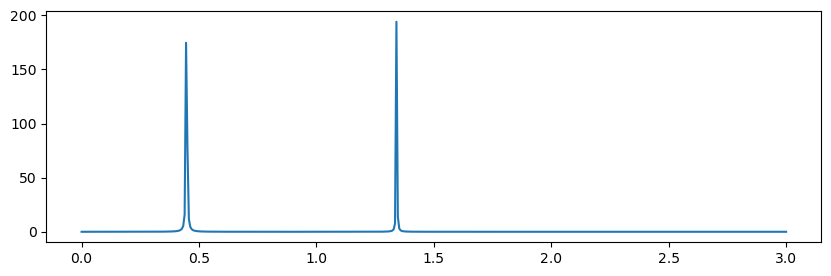

In [113]:
ws = np.linspace(0, 3, 500)
eps = 0.001

plt.plot(ws, matter_response(ws + 1j * eps, 1, 1, 0.4).imag)
plt.show()

In [241]:
aux = np.linspace(1, 100, 20)
for i, val in enumerate(aux[1:]):
    print(i, val)

0 6.2105263157894735
1 11.421052631578947
2 16.63157894736842
3 21.842105263157894
4 27.052631578947366
5 32.26315789473684
6 37.473684210526315
7 42.68421052631579
8 47.89473684210526
9 53.10526315789473
10 58.315789473684205
11 63.526315789473685
12 68.73684210526315
13 73.94736842105263
14 79.1578947368421
15 84.36842105263158
16 89.57894736842105
17 94.78947368421052
18 100.0
